In [1]:
import sys, os, glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import warnings
from scipy.stats import percentileofscore

# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

%matplotlib inline
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'
# plt.rcParams['pdf.fonttype'] = 42

# make a folder to store figures if not already there
!mkdir ../jupyter_figures


mkdir: ../jupyter_figures: File exists


In [2]:
def plot_cum_dist(data, n_bins=None, output_fig_path=None,
                  x_ticks=None, y_ticks=None, y_log_scale=False,
                  x_max=None, y_max=None,
                  fig_width=1.0, fig_height=1.0,
                  clipping_removal=True, axis_off=False):
    '''Plot a black curve and a blue histogram representing cumulative distribution of data
    '''
    
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    
    ax = sns.kdeplot(data, cumulative=True, linewidth=0.8, legend=False, color='k')
    
    plt.hist(data, bins=n_bins, cumulative=True, density=True, color='Blue', rwidth=.9, alpha=.6)
#     ax = sns.distplot(data, kde=False, hist_kws={'cumulative': True, 'rwidth': .9, 'alpha': .5}, norm_hist=True, color='Blue')

    plt.ylabel("Cumulative\nfraction of data")
    
    if x_ticks is not None:
        plt.xticks(x_ticks)
        
    if x_max is not None:
        plt.xlim( [min(data), x_max] )
        
    if y_log_scale == True:
    # seems to have issues, may address in the future
        ax.set(yscale="log")
    else:
        if y_ticks is not None:
            plt.yticks(y_ticks)

        if y_max is not None:
            plt.ylim( [0, y_max] )

    if clipping_removal == True:
        # The following removes excessive clipping to facilitate detailing
        # of line widths and colors etc. in illustrator
        # *** Note that removing clipping causes issues for log scale ***
        for o in fig.findobj():
            o.set_clip_on(False)
        for o in ax.findobj():
            o.set_clip_on(False)

    if axis_off == True:
        plt.axis("off")
        
    if output_fig_path is not None:
        plt.savefig(output_fig_path)
    
    return ax

def plot_dist(data, output_fig_path=None,
              kde=True, n_bins=None, norm_hist=True,
              x_ticks=None, x_max=None, x_label=None,
              y_ticks=None, y_max=None, y_log_scale=False,
              fig_width=1.0, fig_height=1.0,
              clipping_removal=True, axis_off=False):
    '''Plot a black curve and a blue histogram representing cumulative distribution of data
    '''
    
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    
    if kde==True:
        ax = sns.kdeplot(data, cumulative=False, linewidth=0.8, legend=False, color='k')
    
    plt.hist(data, bins=n_bins, cumulative=False, density=norm_hist, color='Blue', rwidth=.9, alpha=.6)
#     ax = sns.distplot(data, kde=False, hist_kws={'cumulative': False, 'rwidth': .9, 'alpha': .6}, norm_hist=norm_hist, color='Blue')
    
    if norm_hist == True:
        plt.ylabel("Probablity density")
    else:
        plt.ylabel("Count of data")
    
    if x_label is not None:
        plt.xlabel(x_label)
        
    if x_ticks is not None:
        plt.xticks(x_ticks)
        
    if x_max is not None:
        plt.xlim( [min(data), x_max] )
        
    if y_log_scale == True:
    # seems to have issues, may address in the future
        ax.set(yscale="log")
    else:
        if y_ticks is not None:
            plt.yticks(y_ticks)

        if y_max is not None:
            plt.ylim( [0, y_max] )

    if clipping_removal == True:
        # The following removes excessive clipping to facilitate detailing
        # of line widths and colors etc. in illustrator
        # *** Note that removing clipping causes issues for log scale ***
        for o in fig.findobj():
            o.set_clip_on(False)
        for o in ax.findobj():
            o.set_clip_on(False)
    
    if axis_off == True:
        plt.axis("off")
    
    if output_fig_path is not None:
        plt.savefig(output_fig_path)
    
    return ax

def plot_track_distance_to_surface(df, output_fig_path=None,
                                   N_tracks=200, fig_width=1.5, fig_height=1.0, rand_seed=7):
    assert 'TrackID' in df.columns
    assert 'Distance' in df.columns
    
    fig = plt.figure(figsize=(1.5, 1.0), dpi=300)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    tracks = df.TrackID.unique()
    # Plot N randomly chosen tracks to show most movement of surface-proximal tracks move within the surface
    np.random.seed(rand_seed)
    track_count = 0
    for i in np.random.randint(0, len(tracks), N_tracks*100):
        # Get the data frame subset of current track
        df_temp = df[ df.TrackID==tracks[i] ]
        # Filter out short tracks
        if len(df_temp)<36:
            continue
        # Filter out very long tracks that tends to contain errors
        if len(df_temp)>120:
            continue

        # Filter out tracks with positive distance,
        # which are likely outside of the epithelial surface
        if pd.Series(df_temp.Distance>-3).any():
            continue

        # Normalize the x-axis to make the plot cleaner
        x = np.arange(len(df_temp))/(len(df_temp)-1)
#         plt.plot(x, df_temp.Distance, alpha=0.2, lw=0.4)
        plt.plot(x, df_temp.Distance, alpha=0.1, lw=0.4, color='k')

        track_count += 1
        if track_count > N_tracks:
            break

    # Check whether desired number of plot were obtained
    assert track_count == N_tracks + 1
    
    plt.xlabel('Relative track time')
    plt.ylabel("Distance to\nepithelial surface")
    plt.ylim( [-50, 0] )
    plt.yticks( [-45, -30, -15, 0])

    # The following removes excessive clipping to facilitate detailing of line widths and colors etc in illustrator
    for o in fig.findobj():
        o.set_clip_on(False)
    for o in ax.findobj():
        o.set_clip_on(False)
    
    if output_fig_path is not None:
        plt.savefig(output_fig_path)

    return ax


In [3]:
track_file = '../data/imaris-overall-tracking-data/Tracks-surface-proximal/2020-01-25-K14R-HisG-2photon-25x-2-denoised_Shortest_Distance_to_Surfaces_Surfaces=Surfaces_1.csv'
output_prefix = '2020-01-25-K14R-HisG-2photon-25x-2-denoised-surface-proximal-tracks'
df = pd.read_csv(track_file, skiprows=3)
df.rename(columns={'Shortest Distance to Surfaces':'Distance'}, inplace=True)
df.head()


,Distance,Unit,Category,Surfaces,Time,TrackID,ID,Unnamed: 7
0,-3.79688,um,Spot,Surfaces 1,25,1000000000,0,NaN
1,-6.42798,um,Spot,Surfaces 1,25,1000000001,1,NaN
2,-6.48458,um,Spot,Surfaces 1,25,1000000002,2,NaN
3,-7.88086,um,Spot,Surfaces 1,25,1000000003,3,NaN
4,-7.83211,um,Spot,Surfaces 1,25,1000000004,4,NaN


In [4]:
df.describe()

,Distance,Time,TrackID,ID,Unnamed: 7
count,392672.000000,392672.000000,3.926720e+05,392672.000000,0.0
mean,-11.618291,162.885383,1.000157e+09,196335.500000,NaN
std,6.051425,75.696301,1.131036e+05,113354.786788,NaN
min,-47.325500,25.000000,1.000000e+09,0.000000,NaN
25%,-14.591600,98.000000,1.000053e+09,98167.750000,NaN
50%,-9.694420,167.000000,1.000153e+09,196335.500000,NaN
75%,-7.631032,229.000000,1.000250e+09,294503.250000,NaN
max,30.954000,289.000000,1.000383e+09,392671.000000,NaN


In [5]:
# Filter out tracks that go outside of the surface
# These tracks are mesenchyme tracks closely delineating the surface
# that got selected when the simple minimal distance criteria was used to filter tracks in Imaris
tracks_to_drop = []
for track in df.TrackID.unique():
    df_temp = df[df.TrackID==track]
    track_max_dist_temp = np.max(df_temp.Distance)
    if track_max_dist_temp >= 0:
        tracks_to_drop.append(track)
print("Total number of tracks to drop: ", len(tracks_to_drop))

df_filtered = df[~df.TrackID.isin(tracks_to_drop)]


Total number of tracks to drop:  59


In [6]:
print("Total number of tracks before filtering: ", df.TrackID.nunique())
print("Total number of spots before filtering: ", len(df))
print("Total number of tracks after filtering: ", df_filtered.TrackID.nunique())
print("Total number of spots after filtering: ", len(df_filtered))

Total number of tracks before filtering:  14867
Total number of spots before filtering:  392672
Total number of tracks after filtering:  14808
Total number of spots after filtering:  389899


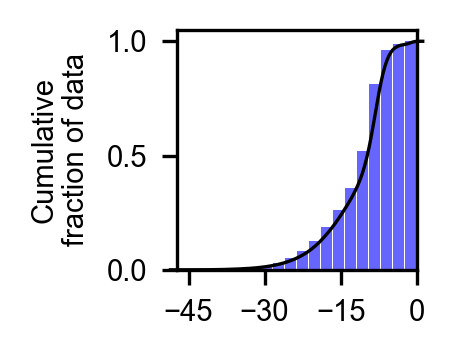

In [7]:
output_file_name = '../jupyter_figures/' + output_prefix + '-CDF-spot-distance-to-surface.svg'
plot_cum_dist(df_filtered.Distance, output_fig_path=output_file_name, n_bins=20,
              x_max=0, x_ticks=[-45, -30, -15, 0], y_ticks=[0.0, 0.5, 1.0])


In [8]:
# Find out at which value the cumulative fraction reaches 1.0
np.percentile(df_filtered.Distance, 100)


-0.0646366

In [9]:
# Find the corresponding percentile of specified value
percentileofscore(df_filtered.Distance, -15)


23.774233840045756

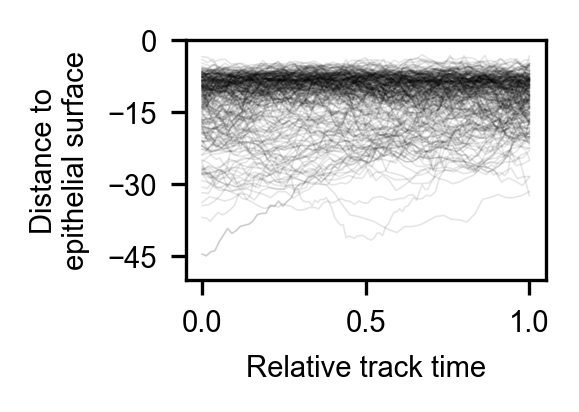

In [10]:
output_file_name = '../jupyter_figures/' + output_prefix + '-line-plot-track-distance-to-surface-N250.svg'
plot_track_distance_to_surface(df_filtered, output_fig_path=output_file_name, N_tracks=250)

# output_file_name = '../jupyter_figures/' + output_prefix + '-line-plot-track-distance-to-surface-N200.svg'
# plot_track_distance_to_surface(df_filtered, output_fig_path=output_file_name, N_tracks=200)

# output_file_name = '../jupyter_figures/' + output_prefix + '-line-plot-track-distance-to-surface-N500.svg'
# plot_track_distance_to_surface(df_filtered, output_fig_path=output_file_name, N_tracks=500)


In [11]:
# Read in data of track duration for all tracks
track_file = '../data/imaris-overall-tracking-data/Tracks-all/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Track_Duration.csv'
df_all = pd.read_csv(track_file, skiprows=3)
df_all.rename(columns={'Track Duration':'Track_Duration'}, inplace=True)
df_all.head()

# Read in data of track duration for epithelial tracks
track_file = '../data/imaris-overall-tracking-data/Tracks-epithelial/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Track_Duration.csv'
df_epi = pd.read_csv(track_file, skiprows=3)
df_epi.rename(columns={'Track Duration':'Track_Duration'}, inplace=True)
df_epi.head()

# Read in data of track duration for surface-proximal tracks
track_file = '../data/imaris-overall-tracking-data/Tracks-surface-proximal/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Track_Duration.csv'
df_surf = pd.read_csv(track_file, skiprows=3)
df_surf.rename(columns={'Track Duration':'Track_Duration'}, inplace=True)
df_surf.head()


,Track_Duration,Unit,Category,ID,Unnamed: 4
0,1.33372,h,Track,1000000000,NaN
1,1.33372,h,Track,1000000001,NaN
2,1.66681,h,Track,1000000002,NaN
3,1.91664,h,Track,1000000003,NaN
4,7.91669,h,Track,1000000004,NaN


In [12]:
# Find the corresponding percentile of specified value
percentileofscore(df_all.Track_Duration, 18.0)
# Identify the percentile
np.percentile(df_all.Track_Duration, 100)
# np.median(df_all.Track_Duration)


22.0003

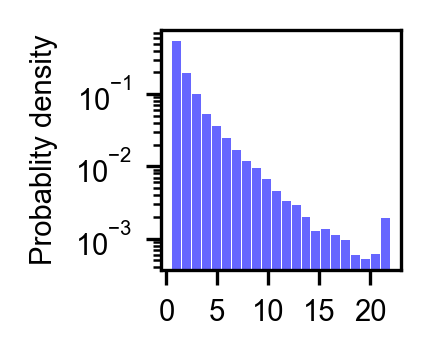

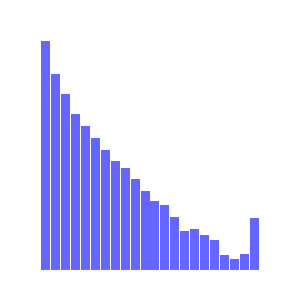

In [13]:
output_prefix = '2020-01-25-K14R-HisG-2photon-25x-4-denoised-all-tracks'
output_file_name = '../jupyter_figures/' + output_prefix + '-Track-Duration-Distribution-y-log-with-clipping.svg'
plot_dist(df_all.Track_Duration, output_fig_path=output_file_name,
          n_bins=22, y_log_scale=True, x_ticks=[0, 5, 10, 15, 20], kde=False, clipping_removal=False)


output_prefix = '2020-01-25-K14R-HisG-2photon-25x-4-denoised-all-tracks'
output_file_name = '../jupyter_figures/' + output_prefix + '-Track-Duration-Distribution-y-log.png'
plot_dist(df_all.Track_Duration, output_fig_path=output_file_name,
          n_bins=22, y_log_scale=True, x_ticks=[0, 5, 10, 15, 20], kde=False, clipping_removal=False, axis_off=True)


In [15]:
# Read in data of mean track speed for all tracks
track_file = '../data/imaris-overall-tracking-data/Tracks-all/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Track_Speed_Mean.csv'
df_all = pd.read_csv(track_file, skiprows=3)
df_all.rename(columns={'Track Speed Mean':'Mean_Track_Speed'}, inplace=True)
df_all.head()

# Read in data of mean track speed for epithelial tracks
track_file = '../data/imaris-overall-tracking-data/Tracks-epithelial/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Track_Speed_Mean.csv'
df_epi = pd.read_csv(track_file, skiprows=3)
df_epi.rename(columns={'Track Speed Mean':'Mean_Track_Speed'}, inplace=True)
df_epi.head()

# Read in data of mean track speed for surface-proximal tracks
track_file = '../data/imaris-overall-tracking-data/Tracks-surface-proximal/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Track_Speed_Mean.csv'
df_surf = pd.read_csv(track_file, skiprows=3)
df_surf.rename(columns={'Track Speed Mean':'Mean_Track_Speed'}, inplace=True)
df_surf.head()


,Mean_Track_Speed,Unit,Category,ID,Unnamed: 4
0,14.7511,um/h,Track,1000000000,NaN
1,16.3517,um/h,Track,1000000001,NaN
2,17.6142,um/h,Track,1000000002,NaN
3,16.1624,um/h,Track,1000000003,NaN
4,16.3708,um/h,Track,1000000004,NaN


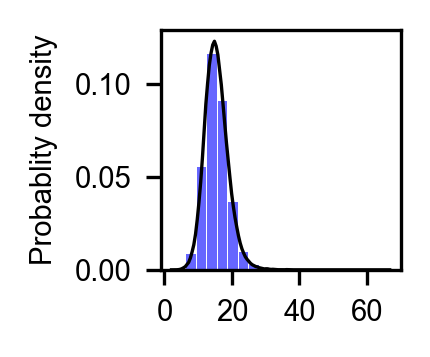

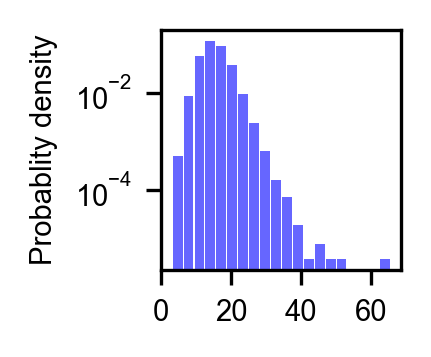

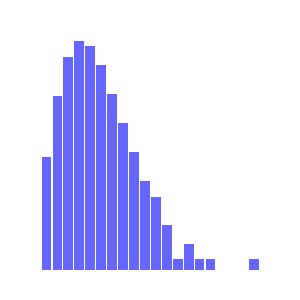

In [17]:
# Plot the distribution of all three track selections
output_prefix = '2020-01-25-K14R-HisG-2photon-25x-4-denoised'
output_file_name = '../jupyter_figures/' + output_prefix + '-all-tracks-Mean-Track-Speed-Distribution.svg'
plot_dist(df_all.Mean_Track_Speed, n_bins=20,
#           x_ticks=[0, 25, 50, 75], x_max=75,
          x_ticks=[0, 20, 40, 60],
          output_fig_path=output_file_name)

output_file_name = '../jupyter_figures/' + output_prefix + '-all-tracks-Mean-Track-Speed-Distribution-y-log.svg'
plot_dist(df_all.Mean_Track_Speed, n_bins=20,
          x_ticks=[0, 20, 40, 60],
          y_log_scale=True, kde=False,
          output_fig_path=output_file_name,
          clipping_removal=False)

output_file_name = '../jupyter_figures/' + output_prefix + '-all-tracks-Mean-Track-Speed-Distribution-y-log.png'
plot_dist(df_all.Mean_Track_Speed, n_bins=20,
          x_ticks=[0, 20, 40, 60],
          y_log_scale=True, kde=False,
          output_fig_path=output_file_name,
          clipping_removal=False, axis_off=True)


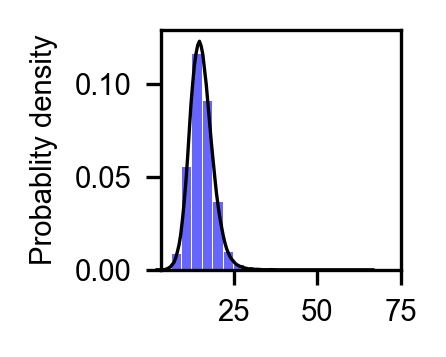

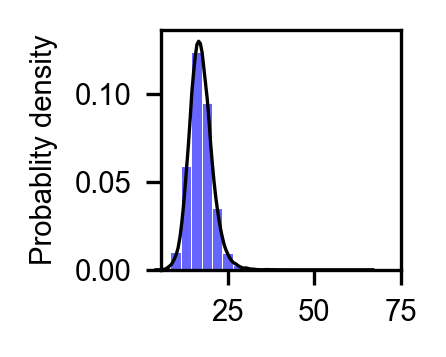

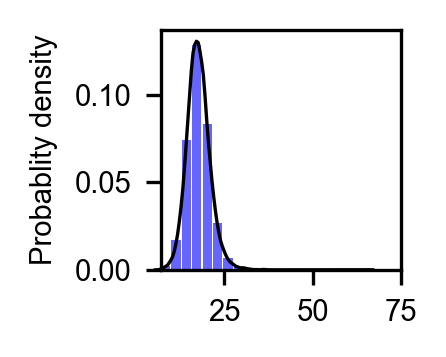

In [18]:
# Plot the distribution of all three track selections
plot_dist(df_all.Mean_Track_Speed, n_bins=20, x_ticks=[0, 25, 50, 75], x_max=75)
plot_dist(df_epi.Mean_Track_Speed, n_bins=20, x_ticks=[0, 25, 50, 75], x_max=75)
plot_dist(df_surf.Mean_Track_Speed, n_bins=20, x_ticks=[0, 25, 50, 75], x_max=75)


In [19]:
print('Track number of all tracks: ', len(df_all))
print('Track number of epithelial tracks: ', len(df_epi))
print('Track number of surface-proximal epithelial tracks: ', len(df_surf))

Track number of all tracks:  83813
Track number of epithelial tracks:  22050
Track number of surface-proximal epithelial tracks:  11781


In [20]:
# Check whether track ID was inherited: it was NOT
len(set(df_epi.ID.unique()).intersection(set(df_surf.ID.unique())))

1122

In [21]:
# Read in track straightness data for all tracks (x,y,z positions for each spot)
track_file = '../data/imaris-overall-tracking-data/Tracks-all/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Track_Straightness.csv'
df_all = pd.read_csv(track_file, skiprows=3)
df_all.rename(columns={'Track Straightness':'Track_Straightness'}, inplace=True)
df_all.head()

# Read in track straightness data for all tracks (x,y,z positions for each spot)
track_file = '../data/imaris-overall-tracking-data/Tracks-epithelial/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Track_Straightness.csv'
df_epi = pd.read_csv(track_file, skiprows=3)
df_epi.rename(columns={'Track Straightness':'Track_Straightness'}, inplace=True)
df_epi.head()

# Read in track straightness data for all tracks (x,y,z positions for each spot)
track_file = '../data/imaris-overall-tracking-data/Tracks-surface-proximal/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Track_Straightness.csv'
df_surf = pd.read_csv(track_file, skiprows=3)
df_surf.rename(columns={'Track Straightness':'Track_Straightness'}, inplace=True)
df_surf.head()


,Track_Straightness,Unit,Category,ID,Unnamed: 4
0,0.540079,NaN,Track,1000000000,NaN
1,0.238043,NaN,Track,1000000001,NaN
2,0.256855,NaN,Track,1000000002,NaN
3,0.426676,NaN,Track,1000000003,NaN
4,0.286270,NaN,Track,1000000004,NaN


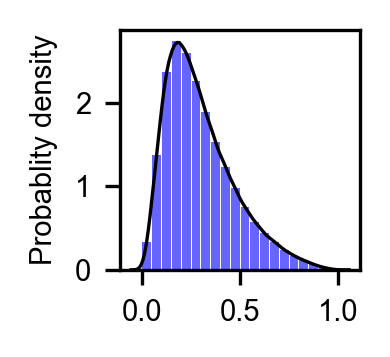

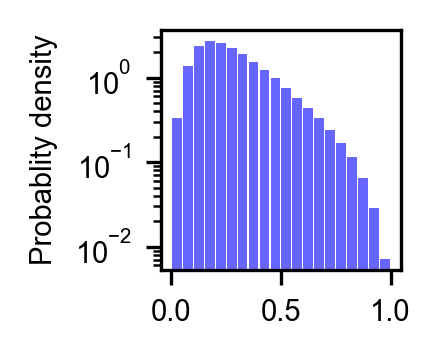

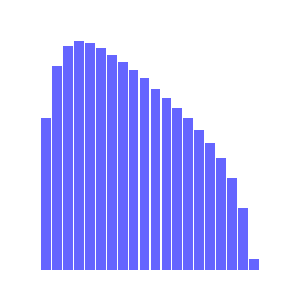

In [22]:
output_prefix = '2020-01-25-K14R-HisG-2photon-25x-4-denoised'

output_file_name = '../jupyter_figures/' + output_prefix + '-all-tracks-Track-Straightness-Distribution.svg'
plot_dist(df_all.Track_Straightness, n_bins=20,
          x_ticks=[0, 0.5, 1.0],
          output_fig_path=output_file_name)

output_file_name = '../jupyter_figures/' + output_prefix + '-all-tracks-Track-Straightness-Distribution-y-log.svg'

plot_dist(df_all.Track_Straightness, n_bins=20,
          x_ticks=[0, 0.5, 1.0],
          y_log_scale=True, kde=False,
          output_fig_path=output_file_name,
          clipping_removal=False)

output_file_name = '../jupyter_figures/' + output_prefix + '-all-tracks-Track-Straightness-Distribution-y-log.png'

plot_dist(df_all.Track_Straightness, n_bins=20,
          x_ticks=[0, 0.5, 1.0],
          y_log_scale=True, kde=False,
          output_fig_path=output_file_name,
          clipping_removal=False, axis_off=True)


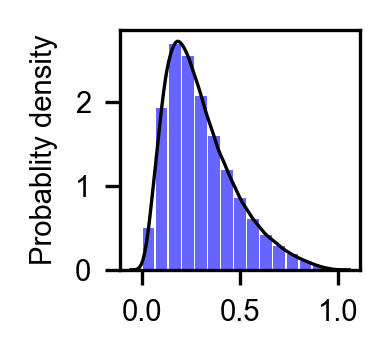

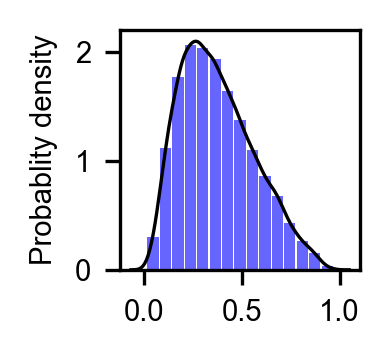

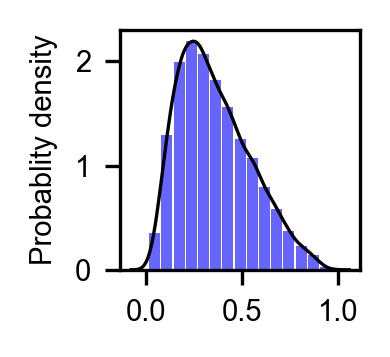

In [23]:
# Plot the distribution of all three track selections
# plot_dist(df_all.Track_Straightness)
plot_dist(df_all.Track_Straightness, n_bins=15, x_ticks=[0, 0.5, 1.0])
plot_dist(df_epi.Track_Straightness, n_bins=15, x_ticks=[0, 0.5, 1.0])
plot_dist(df_surf.Track_Straightness, n_bins=15, x_ticks=[0, 0.5, 1.0])


In [25]:
# Note that spot ID was inherited in the filtering of Imaris,
# which provides a way to select complement set of tracks
#
# Read in the most raw data for all tracks (x,y,z positions for each spot)
track_file = '../data/imaris-overall-tracking-data/Tracks-all/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Position.csv'
df_all = pd.read_csv(track_file, skiprows=3)
df_all.rename(columns={'Position X':'x', 'Position Y':'y', 'Position Z':'z'}, inplace=True)
df_all.head()


,x,y,z,Unit,Category,Collection,Time,TrackID,ID,Unnamed: 9
0,7448.51,-3991.46,1032.25,um,Spot,Position,25,1000000003,3,NaN
1,7540.38,-3988.82,1032.25,um,Spot,Position,25,1000000004,4,NaN
2,7502.64,-3988.28,1032.25,um,Spot,Position,25,1000000005,5,NaN
3,7556.84,-3981.88,1032.25,um,Spot,Position,25,1000000008,8,NaN
4,7510.12,-3974.42,1032.25,um,Spot,Position,25,1000000009,9,NaN


In [26]:
by_time = df_all.groupby('Time')
# spot_count_by_time = by_time['ID'].describe()['count']
# spot_count_by_time

track_count_by_time = by_time['TrackID'].describe()['count']

2020-04-16 10:36:20,029 - INFO - NumExpr defaulting to 8 threads.


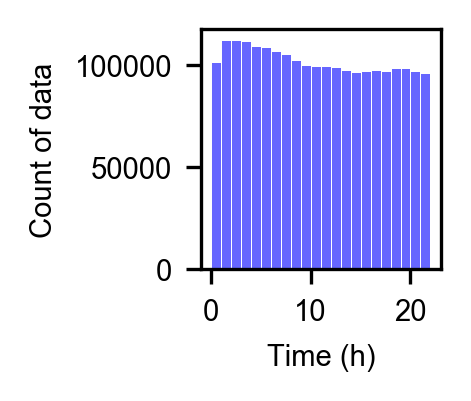

In [27]:
output_prefix = '2020-01-25-K14R-HisG-2photon-25x-4-denoised'
output_file_name = '../jupyter_figures/' + output_prefix + '-tracked-cell-count-over-time.svg'
plot_dist( (df_all.Time - 24) / 12, output_fig_path=output_file_name,
         kde=False, n_bins=22, norm_hist=False,
         x_ticks=[0, 10, 20], x_label='Time (h)')


In [28]:
# Read in the raw data for all tracks (x,y,z positions for each spot)
track_file = '../data/imaris-overall-tracking-data/Tracks-all/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Speed.csv'
df_all_speed = pd.read_csv(track_file, skiprows=3)
# df_all_speed.rename(columns={'Shortest Distance to Surfaces':'Distance'}, inplace=True)
print(df_all_speed.shape)
df_all_speed.head()


(2238132, 7)


,Speed,Unit,Category,Time,TrackID,ID,Unnamed: 6
0,24.07070,um/h,Spot,25,1000000003,3,NaN
1,32.56920,um/h,Spot,25,1000000004,4,NaN
2,4.36720,um/h,Spot,25,1000000005,5,NaN
3,2.50779,um/h,Spot,25,1000000008,8,NaN
4,8.96137,um/h,Spot,25,1000000009,9,NaN


In [30]:
# Read in the distance to surface data for all tracks
track_file = '../data/imaris-overall-tracking-data/Tracks-all/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Shortest_Distance_to_Surfaces_Surfaces=Surfaces_1.csv'
df_all_dist_surf = pd.read_csv(track_file, skiprows=3)
df_all_dist_surf.rename(columns={'Shortest Distance to Surfaces':'Distance'}, inplace=True)
df_all_dist_surf.head()

,Distance,Unit,Category,Surfaces,Time,TrackID,ID,Unnamed: 7
0,246.502,um,Spot,Surfaces 1,25,1000000003,3,NaN
1,215.614,um,Spot,Surfaces 1,25,1000000004,4,NaN
2,223.857,um,Spot,Surfaces 1,25,1000000005,5,NaN
3,205.875,um,Spot,Surfaces 1,25,1000000008,8,NaN
4,208.587,um,Spot,Surfaces 1,25,1000000009,9,NaN


In [31]:
len(set(df_all.ID.unique()).intersection(set(df_all_dist_surf.ID.unique())))

2238132

In [34]:
df_all_dist_surf = df_all_dist_surf.loc[ :, ['Distance', 'ID']]
df_all_dist_surf.head()
df = df_all.merge(df_all_dist_surf, on='ID')


In [35]:
# Select track IDs based on their distance to surface
tracks_epi = []
tracks_surf = []
for track in df.TrackID.unique():
    df_temp = df[df.TrackID==track]
    if np.max(df_temp.Distance) <=0:
        tracks_epi.append(track)
        if np.min(df_temp.Distance) >=-15:
            tracks_surf.append(track)
print("Total number of epithelial tracks: ", len(tracks_epi))
print("Total number of surface epithelial tracks: ", len(tracks_surf))


Total number of epithelial tracks:  23441
Total number of surface epithelial tracks:  9200


In [36]:
print("Total number of all tracks: ", df.TrackID.nunique())
print("Total number of all spots: ", df.ID.nunique())

df_epi = df[df.TrackID.isin(tracks_epi)]
print("Total number of epithelial tracks: ", df_epi.TrackID.nunique())
print("Total number of spots in epithelial cell tracks: ", df_epi.ID.nunique())

df_mes = df[~df.TrackID.isin(tracks_epi)]
print("Total number of mesenchymal tracks: ", df_mes.TrackID.nunique())
print("Total number of spots in mesenchymal tracks: ", df_mes.ID.nunique())

df_surf = df_epi[df_epi.TrackID.isin(tracks_surf)]
print("Total number of surface-proximal epithelial tracks: ", df_surf.TrackID.nunique())
print("Total number of spots in surface-proximal epithelial cell tracks: ", df_surf.ID.nunique())

df_int = df_epi[~df_epi.TrackID.isin(tracks_surf)]
print("Total number of interior epithelial tracks: ", df_int.TrackID.nunique())
print("Total number of spots in interior epithelial cell tracks: ", df_int.ID.nunique())


Total number of all tracks:  83813
Total number of all spots:  2238132
Total number of epithelial tracks:  23441
Total number of spots in epithelial cell tracks:  497437
Total number of mesenchymal tracks:  60372
Total number of spots in mesenchymal tracks:  1740695
Total number of surface-proximal epithelial tracks:  9200
Total number of spots in surface-proximal epithelial cell tracks:  172553
Total number of interior epithelial tracks:  14241
Total number of spots in interior epithelial cell tracks:  324884


In [37]:
# Read in data of mean track speed for all tracks
track_file = '../data/imaris-overall-tracking-data/Tracks-all/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Track_Speed_Mean.csv'
df_all_speed = pd.read_csv(track_file, skiprows=3)
df_all_speed.rename(columns={'Track Speed Mean':'Mean_Track_Speed'}, inplace=True)

print(df_all_speed.shape)
df_all_speed.head()


(83813, 5)


,Mean_Track_Speed,Unit,Category,ID,Unnamed: 4
0,15.4576,um/h,Track,1000000003,NaN
1,18.5319,um/h,Track,1000000004,NaN
2,12.1088,um/h,Track,1000000005,NaN
3,14.4088,um/h,Track,1000000008,NaN
4,14.1189,um/h,Track,1000000009,NaN


In [40]:
# Annotate epithelial vs. mesenchymal track ID in speed data frame for violin plot
df_epi_speed = df_all_speed[df_all_speed.ID.isin(df_epi.TrackID)]
print(df_epi_speed.shape)
df_epi_speed.head()
df_epi_speed['epi_mes_ID'] = ['epi'] * len(df_epi_speed)

df_mes_speed = df_all_speed[df_all_speed.ID.isin(df_mes.TrackID)]
print(df_mes_speed.shape)
df_mes_speed.head()
df_mes_speed['epi_mes_ID'] = ['mes'] * len(df_mes_speed)

df_epi_mes_speed = pd.concat([df_epi_speed, df_mes_speed])
print(df_epi_mes_speed.shape)


(23441, 5)
(60372, 5)
(83813, 6)


/Users/wangs20/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/wangs20/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


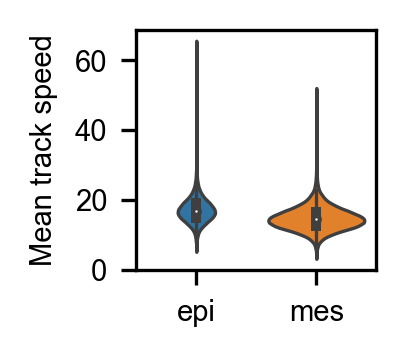

In [41]:
fig = plt.figure(figsize=(1.0, 1.0), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    
sns.violinplot(x='epi_mes_ID', y='Mean_Track_Speed', data=df_epi_mes_speed,
               scale= 'count', cut=0, linewidth=.8)

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

plt.xlabel(None)
plt.ylabel('Mean track speed')
plt.yticks([0, 20, 40, 60])

output_prefix = '2020-01-25-K14R-HisG-2photon-25x-4-denoised'
output_file_name = '../jupyter_figures/' + output_prefix + '-epi-vs-mes-Mean-Track-Speed.svg'

plt.savefig(output_file_name)


In [42]:
# Annotate surface vs. interior epithelial track ID in speed data frame for violin plot
df_surf_speed = df_epi_speed[df_epi_speed.ID.isin(df_surf.TrackID)]
print(df_surf_speed.shape)
# df_surf_speed.head()
df_surf_speed['surf_int_ID'] = ['surface'] * len(df_surf_speed)

df_int_speed = df_epi_speed[df_epi_speed.ID.isin(df_int.TrackID)]
print(df_int_speed.shape)
# df_int_speed.head()
df_int_speed['surf_int_ID'] = ['interior'] * len(df_int_speed)

df_surf_int_speed = pd.concat([df_surf_speed, df_int_speed])
print(df_surf_int_speed.shape)


(9200, 6)
(14241, 6)
(23441, 7)


/Users/wangs20/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/wangs20/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


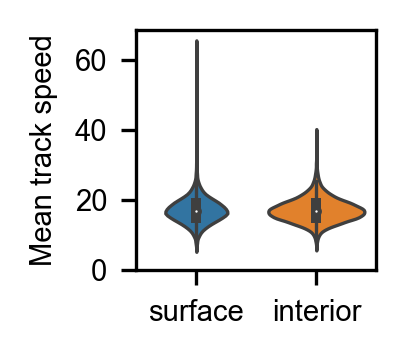

In [43]:
fig = plt.figure(figsize=(1.0, 1.0), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

sns.violinplot(x='surf_int_ID', y='Mean_Track_Speed', data=df_surf_int_speed,
               scale= 'count', cut=0, linewidth=.8)

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

plt.xlabel(None)
plt.ylabel('Mean track speed')
plt.yticks([0, 20, 40, 60])

output_prefix = '2020-01-25-K14R-HisG-2photon-25x-4-denoised'
output_file_name = '../jupyter_figures/' + output_prefix + '-surface-vs-interior-Mean-Track-Speed.svg'

plt.savefig(output_file_name)


In [44]:
from scipy.stats import ttest_ind
res1 = ttest_ind(df_epi_speed.Mean_Track_Speed, df_mes_speed.Mean_Track_Speed)
print(res1)
res2 = ttest_ind(df_surf_speed.Mean_Track_Speed, df_int_speed.Mean_Track_Speed)
print(res2)


Ttest_indResult(statistic=91.22021959657013, pvalue=0.0)
Ttest_indResult(statistic=-3.1027308114062344, pvalue=0.0019197187779561673)


In [45]:
df_epi_mes_speed.groupby('epi_mes_ID').describe()

Mean_Track_Speed                                           \
                      count       mean       std      min        25%   
epi_mes_ID                                                             
epi                 23441.0  17.076083  3.392131  5.16696  14.835500   
mes                 60372.0  14.735010  3.312318  3.16226  12.523675   

                                              ID                ...  \
                 50%       75%      max    count          mean  ...   
epi_mes_ID                                                      ...   
epi         16.87150  19.06680  65.6387  23441.0  1.001511e+09  ...   
mes         14.48385  16.64475  52.0831  60372.0  1.001400e+09  ...   

                                       Unnamed: 4                               
                     75%           max      count mean std min 25% 50% 75% max  
epi_mes_ID                                                                      
epi         1.002375e+09  1.003158e+09        0.0  NaN NaN NaN NaN NaN NaN NaN  
mes         1.002252e+09  1.003158e+09        0.0  NaN NaN NaN NaN NaN NaN NaN  

[2 rows x 24 columns]

In [46]:
df_surf_int_speed.groupby('surf_int_ID').describe()

Mean_Track_Speed                                           \
                       count       mean       std      min        25%   
surf_int_ID                                                             
interior             14241.0  17.131325  3.345821  5.56844  14.888900   
surface               9200.0  16.990571  3.461040  5.16696  14.734775   

                                              ID                ...  \
                  50%      75%      max    count          mean  ...   
surf_int_ID                                                     ...   
interior     16.90670  19.0719  40.2559  14241.0  1.001451e+09  ...   
surface      16.82735  19.0584  65.6387   9200.0  1.001605e+09  ...   

                                        Unnamed: 4                           \
                      75%           max      count mean std min 25% 50% 75%   
surf_int_ID                                                                   
interior     1.002289e+09  1.003156e+09        0.0  NaN NaN NaN NaN NaN NaN   
surface      1.002474e+09  1.003158e+09        0.0  NaN NaN NaN NaN NaN NaN   

                 
            max  
surf_int_ID      
interior    NaN  
surface     NaN  

[2 rows x 24 columns]

In [47]:
# Note that spot ID was inherited in the filtering of Imaris,
# which provides a way to select complement set of tracks
#
# Read in the most raw data for all tracks (x,y,z positions for each spot)
track_file = '../data/imaris-overall-tracking-data/Tracks-all/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Position.csv'
df_all = pd.read_csv(track_file, skiprows=3)
df_all.rename(columns={'Position X':'x', 'Position Y':'y', 'Position Z':'z'}, inplace=True)
df_all.head()

# Read in the most raw data for all tracks (x,y,z positions for each spot)
track_file = '../data/imaris-overall-tracking-data/Tracks-epithelial/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Position.csv'
df_epi = pd.read_csv(track_file, skiprows=3)
df_epi.rename(columns={'Position X':'x', 'Position Y':'y', 'Position Z':'z'}, inplace=True)
df_epi.head()

# Read in the most raw data for all tracks (x,y,z positions for each spot)
track_file = '../data/imaris-overall-tracking-data/Tracks-surface-proximal/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Position.csv'
df_surf = pd.read_csv(track_file, skiprows=3)
df_surf.rename(columns={'Position X':'x', 'Position Y':'y', 'Position Z':'z'}, inplace=True)
df_surf.head()


,x,y,z,Unit,Category,Collection,Time,TrackID,ID,Unnamed: 9
0,7761.12,-3760.66,1032.25,um,Spot,Position,25,1000000000,0,NaN
1,7736.15,-3760.73,1033.50,um,Spot,Position,25,1000000001,1,NaN
2,7740.10,-3750.07,1035.89,um,Spot,Position,25,1000000002,2,NaN
3,7734.93,-3744.67,1035.81,um,Spot,Position,25,1000000003,3,NaN
4,7760.19,-3775.66,1038.22,um,Spot,Position,25,1000000004,4,NaN


In [48]:
print('Track number of all tracks: ', df_all.TrackID.nunique())
print('Track number of epithelial tracks: ', df_epi.TrackID.nunique())
print('Track number of surface-proximal epithelial tracks: ', df_surf.TrackID.nunique())

print('Spot number of all tracks: ', len(df_all))
print('Spot number of epithelial tracks: ', len(df_epi))
print('Spot number of surface-proximal epithelial tracks: ', len(df_surf))


Track number of all tracks:  83813
Track number of epithelial tracks:  22050
Track number of surface-proximal epithelial tracks:  11781
Spot number of all tracks:  2238132
Spot number of epithelial tracks:  476648
Spot number of surface-proximal epithelial tracks:  267403


In [49]:
# Check whether the spot ID was preserved during filtering in Imaris: YES!
len(set(df_epi.ID.unique()).intersection(set(df_surf.ID.unique())))
len(set(df.ID.unique()).intersection(set(df_surf.ID.unique())))

# However, the epithelial selection was somewhat not perfectly inherited,
# which needs to be looked into before using it to sort out data
len(set(df.ID.unique()).intersection(set(df_epi.ID.unique())))


350156

In [50]:
# Use to select out data
df_all_epi_selected = df_all[df_all.ID.isin(df_epi.ID.unique())]

df_all_epi_selected.TrackID.nunique()
# df_all.TrackID.nunique()


19202

16.0

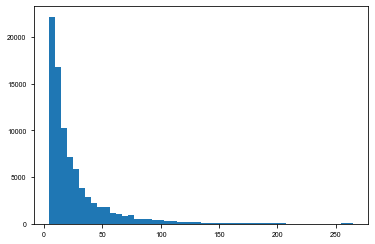

In [51]:
# Use groupby to get track statistics from the position data frame
by_TrackID = df_all.groupby('TrackID')
track_n_spot = df_all.groupby('TrackID')['ID'].count()
plt.hist(track_n_spot, 50)
np.median(track_n_spot)


In [52]:
# Read in the TrackMate exported long-term manual tracking data of cell divisions for plotting
f = '../data/cell-division-tracking-data/180218-mTmGHisG-ROI1-track-info-with-cell-division-id.csv'
df = pd.read_csv(f)
# df.head()

df.sort_values(by=['cell_division_id', 'track_id', 't'], inplace=True)
df.reset_index(inplace=True, drop=True)

# Drop the daughter cells whose tracks were incomplete (goes beyond the FOV or time series)
cell_division_id_to_drop = ['incomplete1A', 'incomplete1B']
df = df[~df.cell_division_id.isin(cell_division_id_to_drop)]

# Remove the A, B postfix to consolidate cell_division id
df.cell_division_id = [i[:-1] for i in df.cell_division_id]

print(df.shape)
df.tail()


(4192, 7)


,cell_division_id,track_id,spot_id,x,y,z,t
4187,9,44,13110,145.390020,124.413351,14.0,59
4188,9,44,13116,144.873354,125.550018,14.0,60
4189,9,44,13122,145.286687,125.756684,14.0,61
4190,9,44,13128,145.183354,124.723351,14.0,62
4191,9,44,13131,146.216687,125.343351,12.0,63


In [53]:
df.cell_division_id.nunique()


42

In [54]:
# In manual tracking using Trackmate, one of the daughter cells begin from the separation of 
# the two daughter cells (anaphase onset).
#
# To plot the tracks that reflect the overlapping origin of both daughter cells, append
# the surface to anaphase onset part of tracks from the matching daughter cell

for cell_division in df.cell_division_id.unique():
# for cell_division in [20]:# for testing
    df_temp = df[df.cell_division_id==str(cell_division)]
#     print(df_temp.shape)
    assert df_temp.track_id.nunique() == 2
    track1 = df_temp[df_temp.track_id==df_temp.track_id.unique()[0]]
    track2 = df_temp[df_temp.track_id==df_temp.track_id.unique()[1]]
    if track1.t.min() < track2.t.min():
        to_add = track1[track1.t < track2.t.min()]
        assert to_add.shape[0] > 0
        to_add.loc[:,'track_id'] = [ df_temp.track_id.unique()[1] ] * to_add.shape[0]
    else:
        to_add = track2[track2.t < track1.t.min()]
        assert to_add.shape[0] > 0
        to_add.loc[:,'track_id'] = [ df_temp.track_id.unique()[0] ] * to_add.shape[0]
    df = pd.concat([df, to_add])
    df.reset_index(inplace=True, drop=True)

df.sort_values(by=['cell_division_id', 'track_id', 't'], inplace=True)
df.reset_index(inplace=True, drop=True)
print(df.shape)


/Users/wangs20/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


(4697, 7)


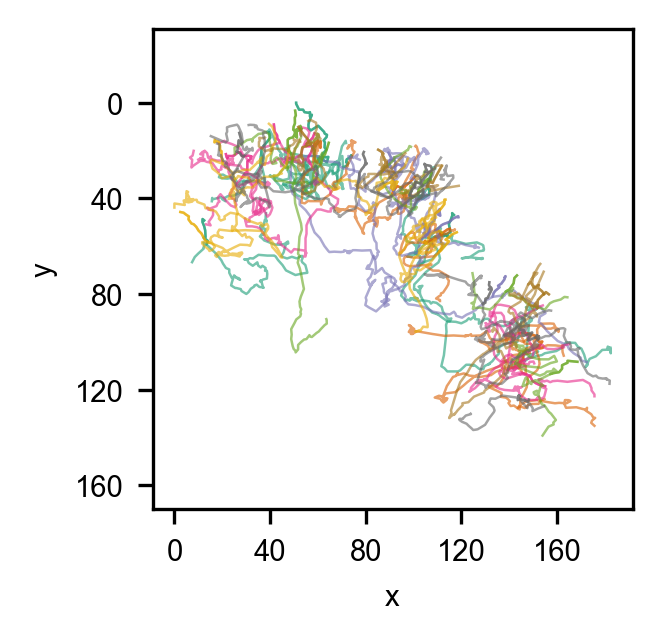

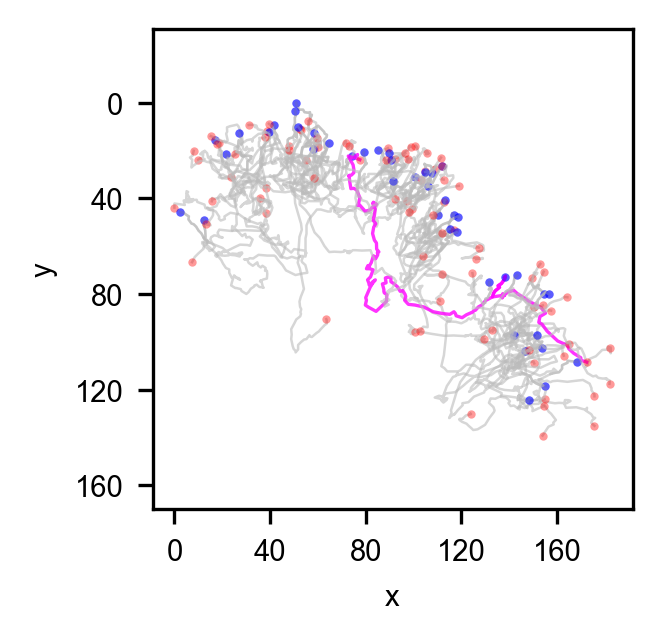

In [56]:
def plot_tracks_2D(trackDF, output_fig_path=None,
                   plot_style='white', line_color=None,
                   track_list=None, tracks_highlight=None,
                   x_ticks=None, y_ticks=None,
                   draw_spot_start=False, draw_spot_end=False):

    from matplotlib import cm
    # Create a colors dictionary to set same color for the daughter cells of the same cell division
    colors = cm.Dark2(np.linspace(0, 1, trackDF.cell_division_id.nunique()))
    colors = [val for pair in zip(colors, colors) for val in pair]

    fig = plt.figure(figsize=(2, 2), dpi=300)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    x_min, y_min = trackDF.x.min(), trackDF.y.min()
    if track_list is None:
        track_list = trackDF.track_id.unique()
    for i, track in enumerate(track_list):
        df_temp = df[df.track_id==track]
        x, y = df_temp.x.values-x_min, df_temp.y.values-y_min
        
        if (tracks_highlight is not None) and (track in tracks_highlight):
            ax.plot(x, y, '-', color='#FF00FF', alpha=.8, lw=.8)
        else:
#             ax.plot(x, y, '-', color=line_color, alpha=.6, lw=.6)
            if line_color is None:
                ax.plot(x, y, '-', color=colors[i], alpha=.6, lw=.6)
            else:
                ax.plot(x, y, '-', color=line_color, alpha=.6, lw=.6)

        if draw_spot_start == True:
            ax.plot(x[0], y[0], 'ob', alpha=.4, markersize=2, markeredgewidth=0)
        if draw_spot_end == True:
            ax.plot(x[-1], y[-1], 'or', alpha=.4, markersize=2, markeredgewidth=0)
    
    # *** add axis labels ***
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # *** set axis ticks if provided ***
    if x_ticks is not None:
        ax.set_xticks(x_ticks)
    if y_ticks is not None:
        ax.set_yticks(y_ticks)
    
    # *** Make the x and y axes equal in dimension to mimic image display ***
    ax.axis('equal')
    
    # *** Flip the y-axis to match the image coordinates ***
    plt.gca().invert_yaxis()
    
    for o in fig.findobj():
        o.set_clip_on(False)
    for o in ax.findobj():
        o.set_clip_on(False)
    
    if output_fig_path is not None:
        plt.savefig(output_fig_path)
    
    return ax

output_filename = '../jupyter_figures/' + '180218-mTmGHisG-ROI1-TrackMate-exported-tracks-2D-all-tracks.svg'
plot_tracks_2D(df, output_fig_path=output_filename,
              x_ticks=np.arange(0, 201, 40), y_ticks=np.arange(0, 201, 40))

output_filename = '../jupyter_figures/' + '180218-mTmGHisG-ROI1-TrackMate-exported-tracks-2D-highlight-tracks.svg'
plot_tracks_2D(df, output_fig_path=output_filename, tracks_highlight=[110, 121],
               x_ticks=np.arange(0, 201, 40), y_ticks=np.arange(0, 201, 40), 
               line_color='#BBBBBB', draw_spot_start=True, draw_spot_end=True)


x, y, z min:  16.5850023219 26.5566703846 12.0
x, y, z max:  199.020027863 165.695023197 88.0
x, y, z min:  16.5850023219 26.5566703846 12.0
x, y, z max:  199.020027863 165.695023197 88.0


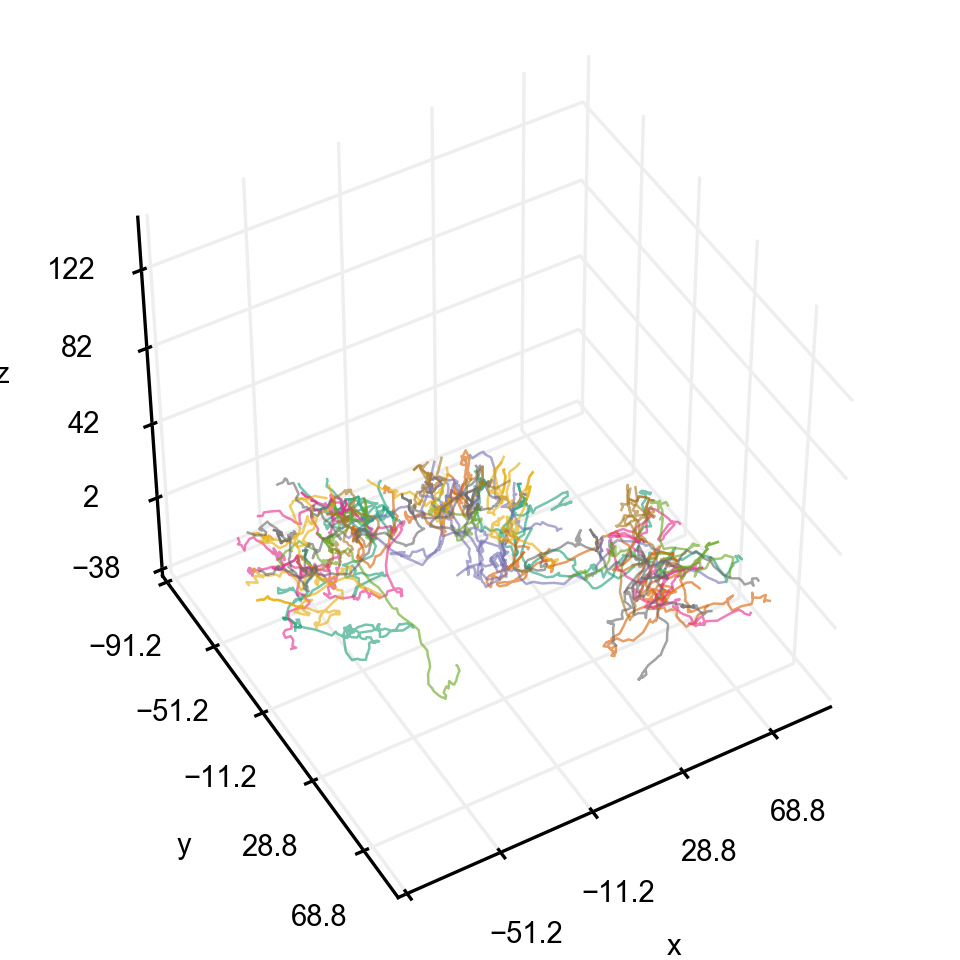

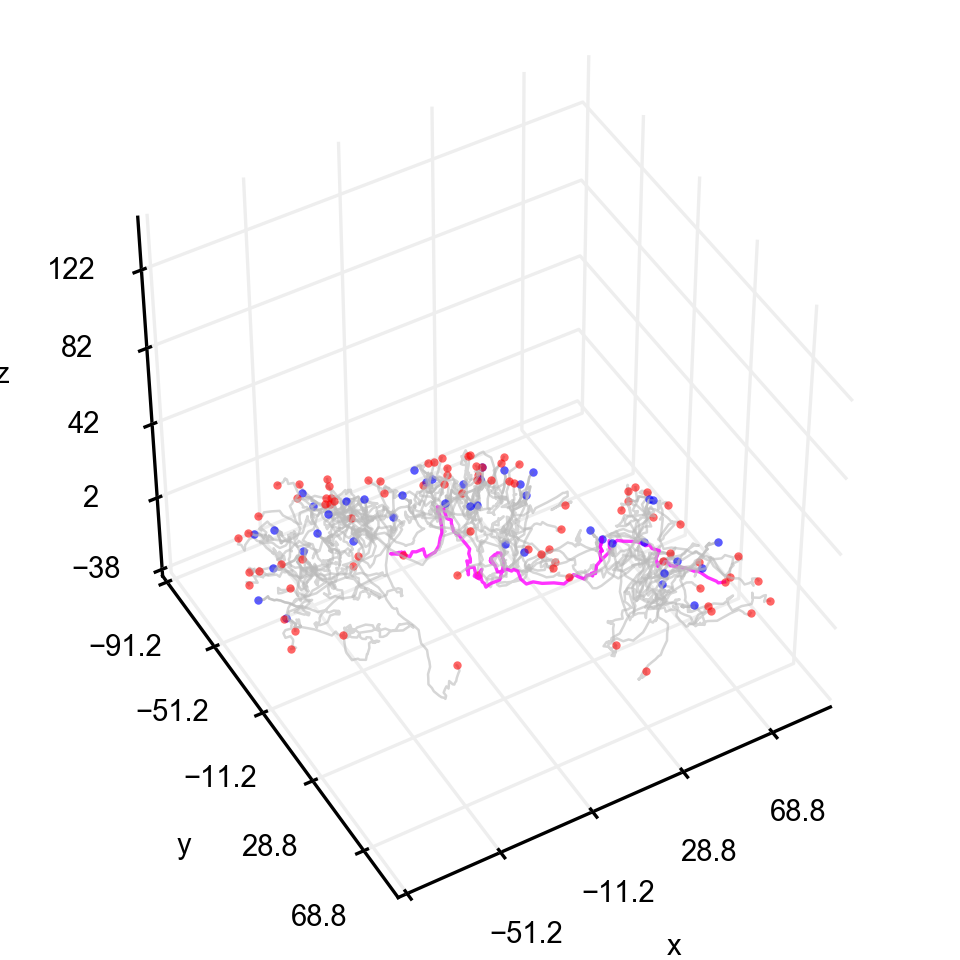

In [58]:
def plot_tracks_3D(trackDF, output_fig_path=None,
                   plot_style='white', line_color=None,
                   track_list=None, tracks_highlight=None,
                   centering=True, draw_spot_start=False, draw_spot_end=False):
    """This script takes the spot position data of all tracks in 3D
    """
#     VOXEL_DEPTH = 2.0 # in micron
#     TIME_INTERVAL = 5.0 # in minutes
    W, H, DPI = 3, 3, 300 # fig size in inches -- make sure W = H since scaling was customized below

    import matplotlib as mpl
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    # Create a colors dictionary to set same color for the daughter cells of the same cell division
#     colors = cm.jet(np.linspace(0, 1, df.cell_division_id.nunique()))
#     colors = cm.Set1(np.linspace(0, 1, df.cell_division_id.nunique()))
    colors = cm.Dark2(np.linspace(0, 1, trackDF.cell_division_id.nunique()))
    colors = [val for pair in zip(colors, colors) for val in pair]
    
    if plot_style=='white':
        AXES_COLOR = '#000000'#black
        mpl.rc('figure', facecolor='w', edgecolor=AXES_COLOR)
        mpl.rc('axes', facecolor='w', edgecolor=AXES_COLOR, labelcolor=AXES_COLOR)
        mpl.rc('xtick', color=AXES_COLOR)
        mpl.rc('ytick', color=AXES_COLOR)
        mpl.rc('grid', color='#EEEEEE')
    
    if plot_style=='dark':
        AXES_COLOR = '#FFFFFF'#white
        mpl.rc('figure', facecolor='k', edgecolor=AXES_COLOR)
        mpl.rc('axes', facecolor='k', edgecolor=AXES_COLOR, labelcolor=AXES_COLOR)
        mpl.rc('xtick', color=AXES_COLOR)
        mpl.rc('ytick', color=AXES_COLOR)
        mpl.rc('grid', color='gray')
    
    # plotting set up
    fig = plt.figure(figsize=(W, H), dpi=DPI)
    ax = fig.add_axes([0, 0, 1.0, 1.0], projection='3d')
    
    if plot_style=='white':
        # *** Set the background color of the panes ***
        PANECOLOR = (1, 1, 1, 1.0) # white
        ax.w_xaxis.set_pane_color(PANECOLOR)
        ax.w_yaxis.set_pane_color(PANECOLOR)
        ax.w_zaxis.set_pane_color(PANECOLOR)
        # *** Set the line colors of x,y,z axes ***
        AXISCOLOR = (0, 0, 0, 1.0) # black
        ax.w_xaxis.line.set_color(AXISCOLOR)
        ax.w_yaxis.line.set_color(AXISCOLOR)
        ax.w_zaxis.line.set_color(AXISCOLOR)

    if plot_style=='dark':
        # *** Set the background color of the panes ***
        # PANECOLOR = (0.1, 0.1, 0.1, 1.0) # dark grey
        PANECOLOR = (0, 0, 0, 1.0) # black
        ax.w_xaxis.set_pane_color(PANECOLOR)
        ax.w_yaxis.set_pane_color(PANECOLOR)
        ax.w_zaxis.set_pane_color(PANECOLOR)
        # *** Set the line colors of x,y,z axes ***
        AXISCOLOR = (1.0, 1.0, 1.0, 1.0) # white
        ax.w_xaxis.line.set_color(AXISCOLOR)
        ax.w_yaxis.line.set_color(AXISCOLOR)
        ax.w_zaxis.line.set_color(AXISCOLOR)
    
    # calculate the range values and scales in each dimension
    tMin, tMax = trackDF.t.min(), trackDF.t.max()
    xMin, xMax = trackDF.x.min(), trackDF.x.max()
    yMin, yMax = trackDF.y.min(), trackDF.y.max()
    zMin, zMax = trackDF.z.min(), trackDF.z.max()
    print('x, y, z min: ', xMin, yMin, zMin)
    print('x, y, z max: ', xMax, yMax, zMax)
    if centering == False:
        shift_x, shift_y, shift_z = 0, 0, 0
    else:
        shift_x, shift_y, shift_z = np.mean([xMax, xMin]), np.mean([yMax, yMin]), np.mean([zMax, zMin])

    if track_list is None:
        track_list = trackDF.track_id.unique()
    for i, track in enumerate(track_list):
        temp = trackDF.loc[trackDF.track_id == track]
        temp = temp.sort_values('t', ascending=True)
        x, y, z = temp.x, temp.y, temp.z
        x, y, z = np.array(x), np.array(y), np.array(z)
        if (tracks_highlight is not None) and (track in tracks_highlight):
            ax.plot(x-shift_x, y-shift_y, z-shift_z, '-', color='#FF00FF', alpha=.8, lw=.8)
        else:
            if line_color is None:
                ax.plot(x-shift_x, y-shift_y, z-shift_z, '-', color=colors[i], alpha=.6, lw=.6)
            else:
                ax.plot(x-shift_x, y-shift_y, z-shift_z, '-', color=line_color, alpha=.6, lw=.6)

        if draw_spot_start == True:
            ax.plot([x[0]-shift_x], [y[0]-shift_y], [z[0]-shift_z], 'ob', alpha=.4, markersize=2, markeredgewidth=0)
        if draw_spot_end == True:
            ax.plot([x[-1]-shift_x], [y[-1]-shift_y], [z[-1]-shift_z], 'or', alpha=.6, markersize=2, markeredgewidth=0)

    # *** adjust axis limits and turn on/off grids -- has to be after plotting ***
    x0, y0, z0 = xMin-shift_x, yMin-shift_y, zMin-shift_z
    if abs(x0) > abs(y0):
        y0 = x0
    else:
        x0 = y0
#     x0, y0, z0 = -100, -100, -40
#     x0, y0, z0 = -95, -95, -40
#     x0, y0, z0 = -120, -120, -40
    axisLength = abs(x0) * 2
    ax.set_xlim( x0, x0 + axisLength )
    ax.set_ylim( y0, y0 + axisLength )
    ax.set_zlim( z0, z0 + axisLength )
    
    # *** customize grid size ***
    grid_size = 40
    ax.set_xticks(np.arange( x0, x0 + axisLength + 1, grid_size))
    ax.set_yticks(np.arange( y0, y0 + axisLength + 1, grid_size))
    ax.set_zticks(np.arange( z0, z0 + axisLength + 1, grid_size))

    # *** add axis labels ***
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

#     ax.grid(False)
    ax.view_init(45, 60) # elevation and azimuth angles for viewpoint settting

    # Flip the y-axis to match the image coordinates
    plt.gca().invert_yaxis()
    
    for o in fig.findobj():
        o.set_clip_on(False)
    for o in ax.findobj():
        o.set_clip_on(False)
    
    if output_fig_path is not None:
        plt.savefig(output_fig_path)
    
    return ax

output_filename = '../jupyter_figures/' + '180218-mTmGHisG-ROI1-TrackMate-exported-tracks-3D-color-by-tracks.svg'
plot_tracks_3D(df, output_fig_path=output_filename,
#                centering=False,
#                line_color='k',
               draw_spot_start=False, draw_spot_end=False)

# output_filename = './jupyter_figures/' + '180218-mTmGHisG-ROI1-TrackMate-exported-tracks-3D-color-black-add-dots.svg'
# plot_tracks_3D(df, output_fig_path=output_filename,
#                line_color='k', draw_spot_start=True, draw_spot_end=True)

output_filename = '../jupyter_figures/' + '180218-mTmGHisG-ROI1-TrackMate-exported-tracks-3D-selected-tracks-highlight.svg'
plot_tracks_3D(df, output_fig_path=output_filename, tracks_highlight=[110, 121],
               line_color='#BBBBBB', draw_spot_start=True, draw_spot_end=True)


In [59]:
# Play with color maps of the matplotlib
from matplotlib import cm
colors = cm.jet(np.linspace(0, 1, df.cell_division_id.nunique()))
cell_division_id = df.cell_division_id.unique()
colorsDict = dict( [ (cell_division_id[i], colors[i]) for i in range(len(colors)) ] )
colorsDict['9']
# colors = iter(cm.rainbow(np.linspace(0, 1, len(meanGFPlist))))


array([0.5, 0. , 0. , 1. ])

In [3]:
# Compare Mean Track Speed in SMG and in DLD-1 spheroids

# Read in data of mean track speed for SMG epithelial tracks
track_file = '../data/imaris-overall-tracking-data/Tracks-epithelial/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Track_Speed_Mean.csv'
df = pd.read_csv(track_file, skiprows=3)
df.rename(columns={'Track Speed Mean':'Mean_Track_Speed'}, inplace=True)
df.head()
df_SMG_epi = df

# Read in data of mean track speed for NLS-mNG tracks in DLD-1 spheroid 1
track_file = '../data/imaris-overall-tracking-data/DLD-1-spheroid-tracks/20200908-d193-d267-1to1-5dpt-980nm-denoised_xy2_Track_Speed_Mean-NLS-mNG.csv'
df = pd.read_csv(track_file, skiprows=3)
df.rename(columns={'Track Speed Mean':'Mean_Track_Speed'}, inplace=True)
df.head()
df_mNG_1 = df

# Read in data of mean track speed for NLS-mNG tracks in DLD-1 spheroid 2
track_file = '../data/imaris-overall-tracking-data/DLD-1-spheroid-tracks/20200908-d193-d267-1to1-5dpt-980nm-denoised_xy3_Track_Speed_Mean-NLS-mNG.csv'
df = pd.read_csv(track_file, skiprows=3)
df.rename(columns={'Track Speed Mean':'Mean_Track_Speed'}, inplace=True)
df.head()
df_mNG_2 = df

# Read in data of mean track speed for NLS-mNG tracks in DLD-1 spheroid 1
track_file = '../data/imaris-overall-tracking-data/DLD-1-spheroid-tracks/20200908-d193-d267-1to1-5dpt-980nm-denoised_xy2_Track_Speed_Mean-NLS-mSL.csv'
df = pd.read_csv(track_file, skiprows=3)
df.rename(columns={'Track Speed Mean':'Mean_Track_Speed'}, inplace=True)
df.head()
df_mSL_1 = df

# Read in data of mean track speed for NLS-mNG tracks in DLD-1 spheroid 1
track_file = '../data/imaris-overall-tracking-data/DLD-1-spheroid-tracks/20200908-d193-d267-1to1-5dpt-980nm-denoised_xy3_Track_Speed_Mean-NLS-mSL.csv'
df = pd.read_csv(track_file, skiprows=3)
df.rename(columns={'Track Speed Mean':'Mean_Track_Speed'}, inplace=True)
df.head()
df_mSL_2 = df


In [4]:
# Annotate tracks in each data frame with their types
df_SMG_epi['type'] = ['SMG_epi'] * len(df_SMG_epi)
df_mNG_1['type'] = ['spheroid_mNG'] * len(df_mNG_1)
df_mNG_2['type'] = ['spheroid_mNG'] * len(df_mNG_2)
df_mSL_1['type'] = ['spheroid_mSL'] * len(df_mSL_1)
df_mSL_2['type'] = ['spheroid_mSL'] * len(df_mSL_2)

df = pd.concat([df_SMG_epi, df_mNG_1, df_mNG_2, df_mSL_1, df_mSL_2])

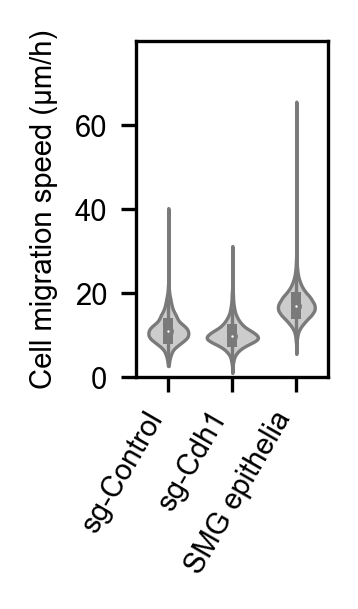

In [22]:
# Make figure for supplemental figure

fig_width, fig_height = 0.8, 1.4
fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

sns.violinplot(data=df, x='type', y='Mean_Track_Speed',
               order=['spheroid_mNG', 'spheroid_mSL', 'SMG_epi'],
               color='.8',
               linewidth=.8, cut=0)

plt.xlabel(None)
plt.ylabel('Cell migration speed (µm/h)')
plt.ylim(0,80)
plt.yticks([0, 20, 40, 60])

# customize x tick labels; sg1-Cdh1
x_labels = ['sg-Control', 'sg-Cdh1', 'SMG epithelia']
ax.set_xticklabels(labels=x_labels, rotation=60, ha="right")

# remove excessory clipping masks
for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

output_prefix = 'Track-speed-spheroids-vs-SMG-violin'
output_file_name = '../jupyter_figures/' + output_prefix + '.svg'

plt.savefig(output_file_name)

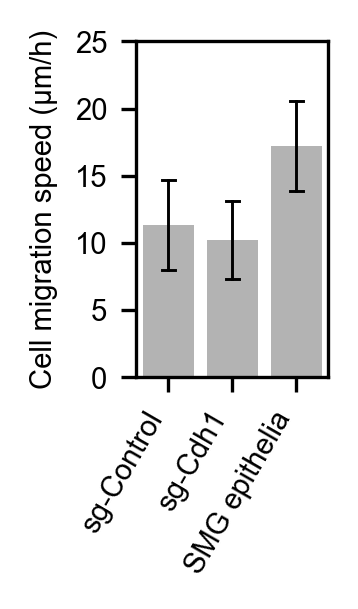

In [26]:
# Make figure for supplemental figure

fig_width, fig_height = 0.8, 1.4
fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

sns.barplot(data=df, x='type', y='Mean_Track_Speed',
            order=['spheroid_mNG', 'spheroid_mSL', 'SMG_epi'],
            color='.7', alpha=1.0,
            errwidth=.7, errcolor="k", capsize=.2, ci='sd')

plt.xlabel(None)
plt.ylabel('Cell migration speed (µm/h)')
plt.ylim(0,25)
# plt.yticks([0, 20, 40, 60])

# customize x tick labels; sg1-Cdh1
x_labels = ['sg-Control', 'sg-Cdh1', 'SMG epithelia']
ax.set_xticklabels(labels=x_labels, rotation=60, ha="right")

# remove excessory clipping masks
for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

output_prefix = 'Track-speed-spheroids-vs-SMG-bar'
output_file_name = '../jupyter_figures/' + output_prefix + '.svg'

plt.savefig(output_file_name)

In [9]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from statsmodels.stats.libqsturng import psturng

def tukeyTest(data, groups, alpha=0.05):
    '''Perform pairwise Tukey test for the data by groups
    '''
    # pairwise comparisons using Tukey's test, calculating p-values
    res = pairwise_tukeyhsd(data, groups, alpha)
    print('Summary of test:\n', res)
    # print(dir(results))# prints out all attributes of an object
    pVal = psturng(np.abs(res.meandiffs / res.std_pairs), len(res.groupsunique), res.df_total)
    print('p values of all pair-wise tests:\n', pVal)

    return res


In [10]:
tukeyTest(df.Mean_Track_Speed, df.type)

Summary of test:
       Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1       group2    meandiff p-adj  lower   upper  reject
---------------------------------------------------------------
     SMG_epi spheroid_mNG  -5.8649 0.001 -6.0682 -5.6617   True
     SMG_epi spheroid_mSL  -6.9904 0.001 -7.1325 -6.8483   True
spheroid_mNG spheroid_mSL  -1.1254 0.001 -1.3623 -0.8886   True
---------------------------------------------------------------
p values of all pair-wise tests:
 [0.001 0.001 0.001]


In [11]:
df.head()

,Mean_Track_Speed,Unit,Category,ID,Unnamed: 4,type
0,14.7511,um/h,Track,1000000000,NaN,SMG_epi
1,16.3517,um/h,Track,1000000001,NaN,SMG_epi
2,17.6142,um/h,Track,1000000002,NaN,SMG_epi
3,16.1624,um/h,Track,1000000003,NaN,SMG_epi
4,16.3708,um/h,Track,1000000004,NaN,SMG_epi
